In [1]:
# hygese module and stable baselines was not working on my macbook therefore I used google colab
# this install is not needed if hygese is already installed in your environment
!pip install "setuptools<58.0.0"
!pip install hygese
!pip install stable-baselines3[extra]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## **Final Solution**

Below you can find our final solution. As explained in detail in the report, we were able successfully shrink the action space by grouping the stores based on their locations. Below you can find how we grouped the stores:

| Group      | Stores |
| ----------- | ----------- |
| Group 1      | 1-2-3-4-5       |
| Group 2      | 6-7-8-9-10         |
| Group 3      | 11       |
| Group 4      | 12-13-14  |
| Group 5      | 15-16-17  |
| Group 6      | 18        |
| Group 7      | 19        |


**PPO**
<br>
Before going to our final solution, we would like to discuss what worked and what not worked for us. After realizing that our REINFORCE algorithm was prone to getting stuck in local optimums and producing unstable results from time to time, we decided to switch using a more state of the art approach called PPO (Proximal Policy Optimization) that is provided within the gym module and is another type of policy gradient method. In their paper on proximal policy optimization, (Schulman, et al. 2017) state that the new method they are proposing enables multiple epochs of minibatch updates whereas standard policy gradient methods such as REINFORCE perform one gradient update per data sample. PPO also uses clipping to take the biggest update step possible without getting too far from the old policy. This was one of the major reasons why we chose to switch to PPO from REINFORCE, to avoid our model from getting stuck at local optimums as much as possible. Another very important reason for the decision to switch was the compatibility of PPO gym spaces. PPO can handle Discrete, Box, MultiBinary, and MultiDicrete action spaces without changing a single line of code. Since we will be trying different action spaces in different models, we thought that the adaptability of PPO will help us a lot to save time during the training.
<br> <br>
**Action Space**
<br>
After trained PPO algorithm gives an output indicating the number of stores to replenish and up to what ratio of order-up-to level to replenish, our model then replenished those stores if their current inventory level is less than $0.9×order-up-to$ level of the store. The stores in the group 1 and group 2 are replenished every day to the inventory level of $1.1×order-up-to$ level of the store since we learned that their transportation cost is rather trivial because they are both close to the warehouse and close the each other. The crucial decision model makes is about the other groups, which are farther from the warehouses and farther from each other. The model output is formulated below.

$output=[(group number, replenishment ratio),...]$ where
<br>
$group number \in [1,2,3,4,5,6,7]$ $and$ 
<br>
$replenishment$ $ratio$ $\in [0.0, 1.1, 2.2]$
<br>
Then, the stores in the groups are replenished to a level of $ratio×order-up-to$ $level$.

In [2]:
# importing the necessary libraries
import gym
from gym import spaces
import numpy as np
import hygese as hgs
import geopy.distance
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import matplotlib.pyplot as plt
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3 import PPO
import pickle

import warnings
warnings.filterwarnings("ignore")

# enable cuda if available
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

with open("lookup.pkl", "rb") as fl:
    ROUTE_LOOKUP = pickle.load(fl)

# Solver initialization
ap = hgs.AlgorithmParameters(timeLimit=0.1)  # seconds
hgs_solver = hgs.Solver(parameters=ap, verbose=False)

class AI4LEnvironment(gym.Env):
    """Joint Replenishment Environment for OpenAI gym"""
    metadata = {'render.modes': ['human']}

    # initialization
    def __init__(self, mode):
        super().__init__()
        self.mode = mode
        # number of stores
        self.nStores = 19
        # data dictionary, needed for hygese solver
        self.data = dict()
        # groups of the stores by their locations
        self.groups = {1: [1, 2, 3, 4, 5],
                       2: [6, 7, 8, 9, 10],
                       3: [11],
                       4: [12, 13, 14],
                       5: [15, 16, 17],
                       6: [18],
                       7: [19]}
        self.lat = np.array([51.46455753,  # arbitrarily selected as depot
                             51.48315348,
                             51.47946524,
                             51.47989288,
                             51.47091165,
                             51.46823832,
                             51.45097352,
                             51.44236109,
                             51.44075611,
                             51.43310493,
                             51.42748611,
                             51.44209359,
                             51.41860162,
                             51.41196388,
                             51.41919040,
                             51.45204327,
                             51.47407462,
                             51.46455753,
                             51.41655806,
                             51.46071441
                             ])

        self.lon = np.array([5.441001338,  # arbitrarily selected as depot
                             5.449615716,
                             5.463520286,
                             5.478883978,
                             5.463348625,
                             5.47776818,
                             5.465205594,
                             5.47979681,
                             5.471642895,
                             5.489753169,
                             5.465033933,
                             5.408385679,
                             5.407870695,
                             5.409587309,
                             5.441001338,
                             5.517476483,
                             5.546744746,
                             5.550177973,
                             5.572865385,
                             5.609406608
                             ])

        # initializing the distance matrix
        self.data['distance_matrix'] = np.zeros(shape=[self.nStores + 1, self.nStores + 1])
        # transportation unit cost
        self.transportCost = 2.5
        # transportation fixed cost
        self.fixedTransportCost = 20

        # calculating the distance matrix that reflects the cost of transportation from a location to another  
        for i in range(0, self.nStores + 1):
            for j in range(0, self.nStores + 1):
                coords_1 = (self.lat[i], self.lon[i])
                coords_2 = (self.lat[j], self.lon[j])
                self.data['distance_matrix'][i][j] = geopy.distance.geodesic(coords_1, coords_2).km * self.transportCost
                if i == 0:
                    self.data['distance_matrix'][i][j] += self.fixedTransportCost
        # we copy the original version of this distance matrix
        # it will be used later to filter the locations for hygese solver
        self.DISTANCE_MATRIX = self.data['distance_matrix'].copy()
        # service times are asssumed to be 0
        self.data['service_times'] = np.zeros(self.nStores + 1)
        # the vehicle capacity, the number of vehicles, and depot information
        # this is stored in the 'data' dict to be compatible with hygese solver
        self.data['vehicle_capacity'] = 100
        self.data['num_vehicles'] = 19
        self.data['depot'] = 0
        # holding cost
        self.c_holding = 1
        # loss sales cost
        self.c_lost = 19
        # capacity of each store
        self.capacity = 1000
        # The maximum to be shipped to a store
        self.maxOrderQuantity = 1000
        # the current amount of inventory in each store
        self.inventories = np.zeros(self.nStores + 1)
        # information on the demand distribution
        # small, medium or large stores: 4, 10, 25 shape par.
        self.demandMean = np.array([0,  # fake depot entry to let indices match
                                    10,
                                    4,
                                    10,
                                    10,
                                    25,
                                    25,
                                    4,
                                    25,
                                    25,
                                    25,
                                    4,
                                    10,
                                    4,
                                    10,
                                    10,
                                    4,
                                    4,
                                    10,
                                    4])
        self.data['demands'] = self.demandMean.copy()
        np.random.seed(1331)
        # standard deviations for the normal distribuiton
        self.demandStdev = np.ceil(np.random.rand(self.nStores + 1) * 0.5 * self.demandMean)
        # create some fixed order up to levels
        self.orderUpTo = np.ceil(self.demandMean + 1.96 * np.sqrt(self.demandStdev))
        # for this case, action space is defined as the number of stores to replenish given a state
        # we set a minimum of 5 stores to be replenished each day to speed up training
        self.action_space = spaces.MultiDiscrete(np.array([1, 1, 3, 3, 3, 3, 3]))
        # observation space is simply the inventory levels at each store at the start of the day
        self.observation_space = spaces.Box(low=0,
                                            high=self.capacity,
                                            shape=(self.nStores + 1,),
                                            dtype=np.int)
        # analytics for bookkeeping purposes
        self.transportCost, self.holdingCost, self.lossSales = [], [], []
        self.counter, self.holdCost, self.salesLoss, self.tCost = 0, 0, 0, 0

    def calcDirectReward(self, ind):
        # ind: indices of the stores that are going to be replenished
        # hygese solver does not cover the edge cases and throw NULL pointer error.
        # therefore we cover those cases by if-else statements to avoid error.
        # warehouse is always in the ind
        # IF TESTING, WE USE THE ACTUAL TRANSPORTATION COSTS COMING FROM THE HYGESE SOLVER
        if self.mode == "test":
            if len(ind) == 1: 
                # cost is 0 if only warehouse in ind
                cost = 0
            elif len(ind) == 2:
                # returning cost of transporation between warehouse and the supermarket
                # in the case where we only replenish 1 store
                # as our policy, we never replenish more than 100, therefore only 1 car is needed
                cost = self.DISTANCE_MATRIX[0][ind[1]] + self.DISTANCE_MATRIX[ind[1]][0]
            else:
                # filtering the distance matrix
                # this is crucial, otherwise hygese visits every store
                self.data['distance_matrix'] = np.take(np.take(self.DISTANCE_MATRIX, ind, axis=0), ind, axis=1)
                # solving
                result = hgs_solver.solve_cvrp(self.data)
                # getting the cost
                cost = result.cost
            return -1 * cost
        # IF TRAINING, WE USE APPROXIMATE TRANSPORTATION COSTS FROM LOOKUP TABLE
        else:
            # if exists, use lookup value
            if tuple(ind) in ROUTE_LOOKUP.keys():
                cost = ROUTE_LOOKUP[tuple(ind)]
            elif len(ind) == 1 or self.data["demands"].sum() == 0: 
                # cost is 0 if only warehouse in ind
                cost = 0
            elif len(ind) == 2:
                # returning cost of transporation between warehouse and the supermarket
                # in the case where we only replenish 1 store
                # as our policy, we never replenish more than 100, therefore only 1 car is needed
                cost = self.DISTANCE_MATRIX[0][ind[1]] + self.DISTANCE_MATRIX[ind[1]][0]
            else:
                # filtering the distance matrix
                # this is crucial, otherwise hygese visits every store
                self.data['distance_matrix'] = np.take(np.take(self.DISTANCE_MATRIX, ind, axis=0), ind, axis=1)
                # solving
                result = hgs_solver.solve_cvrp(self.data)
                # getting the cost
                cost = result.cost
                ROUTE_LOOKUP[tuple(ind)] = cost
            return -1 * cost

    def step(self, action):
        # taking the action
        ind = self._take_action(action)
        # getting the transportation cost
        reward = self.calcDirectReward(ind)
        self.tCost += reward
        self.current_step += 1

        # generating random demand
        demands = np.zeros(self.nStores+1)
        for i in range(1, self.nStores+1):
            demands[i] = int(max(0, np.random.normal(self.demandMean[i], self.demandStdev[i])))
            self.inventories[i] -= demands[i]
            holdCost_temp = max(0, self.inventories[i]) * self.c_holding
            self.holdCost += holdCost_temp
            lossSales_temp = -1 * min(0, self.inventories[i]) * self.c_lost
            self.salesLoss += lossSales_temp
            reward -= (holdCost_temp + lossSales_temp)
            self.inventories[i] = max(0, self.inventories[i])
        # incresing the counter
        self.counter += 1
        # bookkeeping
        if self.counter == 100:
            self.holdingCost.append(self.holdCost / 100)
            self.lossSales.append(self.salesLoss / 100)
            self.transportCost.append(-self.tCost / 100)
            self.holdCost, self.salesLoss, self.tCost = 0, 0, 0
            self.counter = 0

        # our episodes consist of 20 days
        done = self.current_step >= 20
        # observed new state is the updated inventories
        obs = self.inventories
        return obs, reward, done, {}


    def _take_action(self, action):
        # indexes of stores
        ind, rep_ind = [], []
        # looping over the action
        for i, a in enumerate(action):
            # group 1 and 2 will be visited each day
            if i in [0, 1]:
                # looping over the individual stores in the group
                for store in self.groups[i+1]:
                    # mapping action to replenishment ratios
                     ind.append((store, 1.1))
                     rep_ind.append(store)
            # if action is to order for the group
            elif a != 0:
                # looping over the individual stores in the group
                for store in self.groups[i+1]:
                    # mapping action to replenishment ratios
                    ind.append((store, a*1.1))
                    rep_ind.append(store)
        # sorting the indices
        rep_ind.sort()
        # copying the inventory before replenishment
        old_inv = self.inventories.copy()
        rep_ind = [0]
        # looping over the replenishment list and replenishing the stores
        for store, up_to_ratio in ind:
            # if testing mode, 0.9 is used
            if self.mode == "test": ratio = 0.9
            # we don't use 0.9 in training to make model learn policy more freely
            else: ratio = up_to_ratio
            if self.inventories[store] < self.orderUpTo[store] * ratio:
                self.inventories[store] = self.orderUpTo[store] * up_to_ratio
                rep_ind.append(store)
        self.data['demands'] = np.take((self.inventories - old_inv).copy(), rep_ind, axis=0)
        self.data['service_times'] = np.zeros(len(rep_ind))
        return rep_ind

    def analytics(self):
        # returns the basic analytics for plotting
        return self.transportCost, self.holdingCost, self.lossSales
        
    def reset(self):
        # reset the state of the environment to an initial state
        # to be more realistic, we are assigning random ineventory between 0 and 10 to each store.
        self.inventories = np.array([0]+list(np.random.randint(low=0, high=11, size=self.nStores)))
        # resetting the step parameter
        self.current_step = 0
        return self.inventories

    def render(self, mode='human', close=False):
        print("No rendering implemented")

Using cpu device


In [3]:
# initializing the environment in the training mode
env = AI4LEnvironment(mode="train")
# initializing the model
model = PPO("MlpPolicy", env, verbose=1, n_steps=512, batch_size=20, seed=1, learning_rate=0.0005)
# training the model
model.learn(total_timesteps=110000)
# saving the model
model.save("model")

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 20        |
|    ep_rew_mean     | -9.85e+03 |
| time/              |           |
|    fps             | 229       |
|    iterations      | 1         |
|    time_elapsed    | 2         |
|    total_timesteps | 512       |
----------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 20           |
|    ep_rew_mean          | -9.65e+03    |
| time/                   |              |
|    fps                  | 106          |
|    iterations           | 2            |
|    time_elapsed         | 9            |
|    total_timesteps      | 1024         |
| train/                  |              |
|    approx_kl            | 0.0115479175 |
|    clip_fraction        | 0.0821       |
|    clip_range           | 0.2         

In [4]:
# initializing the testing environment
env_test = AI4LEnvironment(mode="test")
# bookkeeping
rewards = []
# 10 episodes
for _ in range(10):
    obs = env_test.reset()
    done = False
    while not done:
        action, _states = model.predict(obs)
        obs, reward, done, info = env_test.step(action)
        print(obs, action, reward)
        rewards.append(reward)
print(np.array(rewards).mean())

[ 0  6  2  4  8  5  9  3 10  5 31  6 17 12 20  4  2  2 18  4] [0 0 1 2 1 2 0] -359.0885101661504
[ 0  6  3  2  9  6 16  3 11  6 28 15  7  9  6  4  3  5  7  0] [0 0 2 0 1 1 0] -304.92575999736357
[ 0  4  5  4  8  5  0  2  8  4 13 11 18  7 17  6  2  6  4  0] [0 0 2 2 1 1 0] -374.40291642878304
[ 0  9  3  3  4  4 24  3  5  4  0  5  9  0 15  5  2  0  7  5] [0 0 1 1 1 1 1] -333.3680830235143
[ 0  8  5  3  0  5  0  4  3  3 10  0 18  9  6 20  8 10  7  3] [0 0 1 2 2 1 1] -527.4276438997102
[ 0  5  5  3  3  3 12  5  0  4 26  4  8  6  0 14  3 10  6  3] [0 0 1 0 1 1 1] -347.8160153657709
[ 0  6  6  4  6  6  5  4  9  3  2  2  4  4  8  7  1  4  4 12] [0 0 1 1 1 1 2] -259.93550644102936
[ 0  5  4  5  5  5  0  3  8  4 12  3 17  9 20  5  3  5  7  7] [0 0 1 2 1 1 0] -468.5916613260475
[ 0  5  3  2  5  4 15  5  7  4  7  7  7  9 14  6  1  2  5  6] [0 0 1 0 1 1 1] -262.0802303302015
[ 0  4  4  2  5  4 11  5  5  6  2  2  0  3  0 20 10 10  1  2] [0 0 1 0 2 1 1] -350.4547028012681
[ 0  2  5  4  5  4  2  0 16

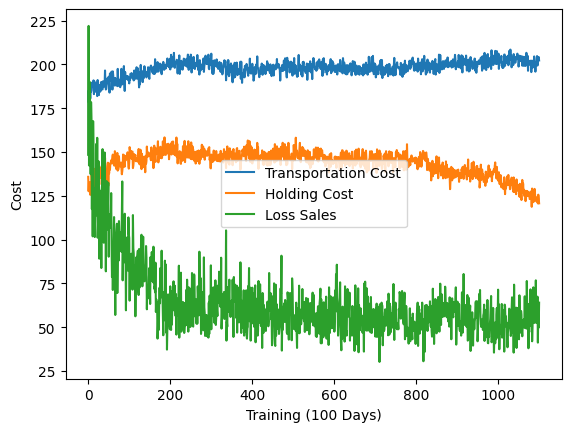

In [5]:
transportCost, holdingCost, lossSales = env.analytics()
# plotting the basic analytics
plt.plot(transportCost, label="Transportation Cost")
plt.plot(holdingCost, label="Holding Cost")
plt.plot(lossSales, label="Loss Sales")
plt.xlabel("Training (100 Days)")
plt.ylabel("Cost")
plt.legend()
plt.show()

In [6]:
# getting the analytics
transportCost, holdingCost, lossSales = env_test.analytics()
print(f"AVERAGE TRANSPORT COST (LAST 500 DAYS): {np.round(np.array(transportCost[-5:]).mean(), 2)}")
print(f"AVERAGE HOLDING COST (LAST 500 DAYS): {np.round(np.array(holdingCost[-5:]).mean(), 2)}")
print(f"AVERAGE LOSS SALES (LAST 500 DAYS): {np.round(np.array(lossSales[-5:]).mean(), 2)}")

AVERAGE TRANSPORT COST (LAST 500 DAYS): 171.21
AVERAGE HOLDING COST (LAST 500 DAYS): 119.36
AVERAGE LOSS SALES (LAST 500 DAYS): 42.28
